In [1]:
# unet_mri_segmentation_final.py

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ======================
# Config
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/kaggle/input/mri-dataset/keras_png_slices_data"
train_images = os.path.join(data_dir, "keras_png_slices_train/")
train_masks = os.path.join(data_dir, "keras_png_slices_seg_train/")
val_images = os.path.join(data_dir, "keras_png_slices_validate/")
val_masks = os.path.join(data_dir, "keras_png_slices_seg_validate/")

batch_size = 16
image_size = 128
epochs = 50
learning_rate = 1e-4   # lowered for stability
save_dir = "./unet_outputs"
os.makedirs(save_dir, exist_ok=True)

# ======================
# Dataset Class
# ======================
class MRISegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Load grayscale MRI slice
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        # Load mask
        mask = np.array(Image.open(mask_path))

        # Remap grayscale values -> 0..C-1
        unique_vals = np.unique(mask)
        val_map = {v: i for i, v in enumerate(unique_vals)}
        mask = np.vectorize(val_map.get)(mask).astype(np.uint8)

        # Resize
        mask = Image.fromarray(mask)
        mask = mask.resize((image_size, image_size), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return img, mask

# ======================
# Detect Number of Classes
# ======================
sample_mask = np.array(Image.open(os.path.join(train_masks, os.listdir(train_masks)[0])))
unique_vals = np.unique(sample_mask)
num_classes = len(unique_vals)
print(f"Unique raw values in sample mask: {unique_vals} → num_classes = {num_classes}")

# ======================
# Transforms
# ======================
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# ======================
# Datasets & Dataloaders
# ======================
train_dataset = MRISegDataset(train_images, train_masks, transform=train_transform)
val_dataset = MRISegDataset(val_images, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ======================
# UNet Model
# ======================
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=num_classes, features=[32, 64, 128]
):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Down path
        for feature in features:
            self.downs.append(nn.Sequential(
                nn.Conv2d(in_channels, feature, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature, feature, 3, padding=1),
                nn.ReLU(inplace=True)
            ))
            in_channels = feature

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1]*2, features[-1]*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Up path
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(feature*2, feature, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature, feature, 3, padding=1),
                nn.ReLU(inplace=True)
            ))

        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

# ======================
# Loss & Metrics
# ======================
def dice_loss(pred, target, epsilon=1e-6):
    pred_soft = F.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0,3,1,2).float()
    inter = (pred_soft * target_onehot).sum(dim=(2,3))
    den = (pred_soft + target_onehot).sum(dim=(2,3)) + epsilon
    dice_per_class = (2*inter + epsilon) / den
    return 1 - dice_per_class.mean()

def dice_coeff_per_class(pred, target, epsilon=1e-6):
    pred_soft = F.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0,3,1,2).float()
    inter = (pred_soft * target_onehot).sum(dim=(0,2,3))
    den = (pred_soft + target_onehot).sum(dim=(0,2,3)) + epsilon
    return (2*inter + epsilon) / den

# ======================
# Initialize Model
# ======================
model = UNet(in_channels=1, out_channels=num_classes).to(device)

# Weighted CE (inverse frequency)
counts = np.bincount(sample_mask.flatten())
counts = counts[counts > 0]  # skip empty background-only values
freq = counts / counts.sum()
weights = 1.0 / (freq + 1e-6)
weights = weights / weights.sum()
print(f"Using class weights: {weights}")

ce_loss = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float, device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ======================
# Training Loop
# ======================
best_val_dice = 0.0
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = dice_loss(outputs, masks) + ce_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    per_class_dice = torch.zeros(num_classes, device=device)
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            per_class_dice += dice_coeff_per_class(outputs, masks)
    per_class_dice /= len(val_loader)
    mean_dice = per_class_dice.mean().item()

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Dice (mean): {mean_dice:.4f}")
    print("Per-class DSC:", per_class_dice.cpu().numpy())

    if mean_dice > best_val_dice:
        best_val_dice = mean_dice
        torch.save(model.state_dict(), os.path.join(save_dir, "unet_best.pth"))
        print("Saved Best Model.")

# ======================
# Visualization Example
# ======================
model.load_state_dict(torch.load(os.path.join(save_dir, "unet_best.pth")))
model.eval()
example_img, example_mask = val_dataset[0]
with torch.no_grad():
    pred = model(example_img.unsqueeze(0).to(device))
    pred_mask = pred.argmax(1).squeeze().cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(example_img[0], cmap="gray")
plt.title("MRI Slice")
plt.subplot(1,2,2)
plt.imshow(example_mask, cmap="gray", alpha=0.5)
plt.imshow(pred_mask, cmap="jet", alpha=0.5)
plt.title("Predicted Mask")
plt.savefig(os.path.join(save_dir, "example_prediction.png"))
plt.close()
print(f"Saved example prediction to {save_dir}/example_prediction.png")


Unique raw values in sample mask: [  0  85 170 255] → num_classes = 4
Using class weights: [0.04187874 0.29138081 0.32290049 0.34383996]


Epoch 1/50: 100%|██████████| 604/604 [04:20<00:00,  2.32it/s]


Epoch 1 | Train Loss: 1.2855 | Val Dice (mean): 0.6143
Per-class DSC: [0.98727405 0.3477048  0.48782343 0.6343354 ]
Saved Best Model.


Epoch 2/50: 100%|██████████| 604/604 [04:23<00:00,  2.29it/s]


Epoch 2 | Train Loss: 1.0994 | Val Dice (mean): 0.6357
Per-class DSC: [0.9901436  0.38950118 0.5265112  0.63675326]
Saved Best Model.


Epoch 3/50: 100%|██████████| 604/604 [04:26<00:00,  2.27it/s]


Epoch 3 | Train Loss: 1.0531 | Val Dice (mean): 0.6515
Per-class DSC: [0.9910637  0.42269275 0.53309345 0.65900624]
Saved Best Model.


Epoch 4/50: 100%|██████████| 604/604 [04:28<00:00,  2.25it/s]


Epoch 4 | Train Loss: 1.0047 | Val Dice (mean): 0.6644
Per-class DSC: [0.99218065 0.44658962 0.5515579  0.667271  ]
Saved Best Model.


Epoch 5/50: 100%|██████████| 604/604 [04:26<00:00,  2.27it/s]


Epoch 5 | Train Loss: 0.9595 | Val Dice (mean): 0.6782
Per-class DSC: [0.99235696 0.4738855  0.57256156 0.6737973 ]
Saved Best Model.


Epoch 6/50: 100%|██████████| 604/604 [04:31<00:00,  2.22it/s]


Epoch 6 | Train Loss: 0.9164 | Val Dice (mean): 0.6849
Per-class DSC: [0.99236655 0.47947007 0.59185535 0.67588794]
Saved Best Model.


Epoch 7/50: 100%|██████████| 604/604 [04:27<00:00,  2.26it/s]


Epoch 7 | Train Loss: 0.8867 | Val Dice (mean): 0.6984
Per-class DSC: [0.9938799  0.50510836 0.5970597  0.6976635 ]
Saved Best Model.


Epoch 8/50: 100%|██████████| 604/604 [04:28<00:00,  2.25it/s]


Epoch 8 | Train Loss: 0.8647 | Val Dice (mean): 0.7046
Per-class DSC: [0.9943899  0.52150625 0.60114974 0.7014637 ]
Saved Best Model.


Epoch 9/50: 100%|██████████| 604/604 [04:31<00:00,  2.22it/s]


Epoch 9 | Train Loss: 0.8468 | Val Dice (mean): 0.7068
Per-class DSC: [0.9947415  0.52351165 0.6009328  0.7080858 ]
Saved Best Model.


Epoch 10/50: 100%|██████████| 604/604 [04:30<00:00,  2.23it/s]


Epoch 10 | Train Loss: 0.8329 | Val Dice (mean): 0.7169
Per-class DSC: [0.99529874 0.542488   0.6054178  0.7245763 ]
Saved Best Model.


Epoch 11/50: 100%|██████████| 604/604 [04:33<00:00,  2.21it/s]


Epoch 11 | Train Loss: 0.8212 | Val Dice (mean): 0.7198
Per-class DSC: [0.9961135  0.5516254  0.6188337  0.71248055]
Saved Best Model.


Epoch 12/50: 100%|██████████| 604/604 [04:34<00:00,  2.20it/s]


Epoch 12 | Train Loss: 0.8116 | Val Dice (mean): 0.7218
Per-class DSC: [0.9960761 0.5542676 0.6161204 0.7209297]
Saved Best Model.


Epoch 13/50: 100%|██████████| 604/604 [04:28<00:00,  2.25it/s]


Epoch 13 | Train Loss: 0.8043 | Val Dice (mean): 0.7225
Per-class DSC: [0.99569005 0.557579   0.61775213 0.7190732 ]
Saved Best Model.


Epoch 14/50: 100%|██████████| 604/604 [04:25<00:00,  2.28it/s]


Epoch 14 | Train Loss: 0.7960 | Val Dice (mean): 0.7267
Per-class DSC: [0.9957852  0.5544639  0.62083215 0.7355253 ]
Saved Best Model.


Epoch 15/50: 100%|██████████| 604/604 [04:29<00:00,  2.24it/s]


Epoch 15 | Train Loss: 0.7894 | Val Dice (mean): 0.7325
Per-class DSC: [0.9959376  0.5658169  0.62565386 0.7425092 ]
Saved Best Model.


Epoch 16/50: 100%|██████████| 604/604 [04:27<00:00,  2.25it/s]


Epoch 16 | Train Loss: 0.7828 | Val Dice (mean): 0.7348
Per-class DSC: [0.996091   0.5659395  0.63931906 0.7379048 ]
Saved Best Model.


Epoch 17/50: 100%|██████████| 604/604 [04:29<00:00,  2.24it/s]


Epoch 17 | Train Loss: 0.7778 | Val Dice (mean): 0.7340
Per-class DSC: [0.9966218 0.5680157 0.6350336 0.7363479]


Epoch 18/50: 100%|██████████| 604/604 [04:27<00:00,  2.26it/s]


Epoch 18 | Train Loss: 0.7716 | Val Dice (mean): 0.7352
Per-class DSC: [0.99722064 0.5800074  0.6332852  0.7301598 ]
Saved Best Model.


Epoch 19/50: 100%|██████████| 604/604 [04:29<00:00,  2.25it/s]


Epoch 19 | Train Loss: 0.7678 | Val Dice (mean): 0.7379
Per-class DSC: [0.99663305 0.57904255 0.6359504  0.7400766 ]
Saved Best Model.


Epoch 20/50: 100%|██████████| 604/604 [04:23<00:00,  2.30it/s]


Epoch 20 | Train Loss: 0.7636 | Val Dice (mean): 0.7397
Per-class DSC: [0.9966896  0.5798104  0.63654673 0.7458321 ]
Saved Best Model.


Epoch 21/50: 100%|██████████| 604/604 [04:36<00:00,  2.19it/s]


Epoch 21 | Train Loss: 0.7597 | Val Dice (mean): 0.7414
Per-class DSC: [0.9966014  0.5816384  0.64277697 0.7445839 ]
Saved Best Model.


Epoch 22/50: 100%|██████████| 604/604 [04:30<00:00,  2.23it/s]


Epoch 22 | Train Loss: 0.7570 | Val Dice (mean): 0.7421
Per-class DSC: [0.9963211  0.58195335 0.6432232  0.7470141 ]
Saved Best Model.


Epoch 23/50: 100%|██████████| 604/604 [04:34<00:00,  2.20it/s]


Epoch 23 | Train Loss: 0.7527 | Val Dice (mean): 0.7410
Per-class DSC: [0.99739337 0.58681315 0.6439074  0.7360786 ]


Epoch 24/50: 100%|██████████| 604/604 [04:39<00:00,  2.16it/s]


Epoch 24 | Train Loss: 0.7503 | Val Dice (mean): 0.7462
Per-class DSC: [0.9972305  0.58937943 0.65161955 0.746628  ]
Saved Best Model.


Epoch 25/50: 100%|██████████| 604/604 [04:45<00:00,  2.11it/s]


Epoch 25 | Train Loss: 0.7475 | Val Dice (mean): 0.7407
Per-class DSC: [0.99686486 0.575386   0.6492935  0.74140775]


Epoch 26/50:  46%|████▌     | 275/604 [02:14<02:40,  2.05it/s]


KeyboardInterrupt: 

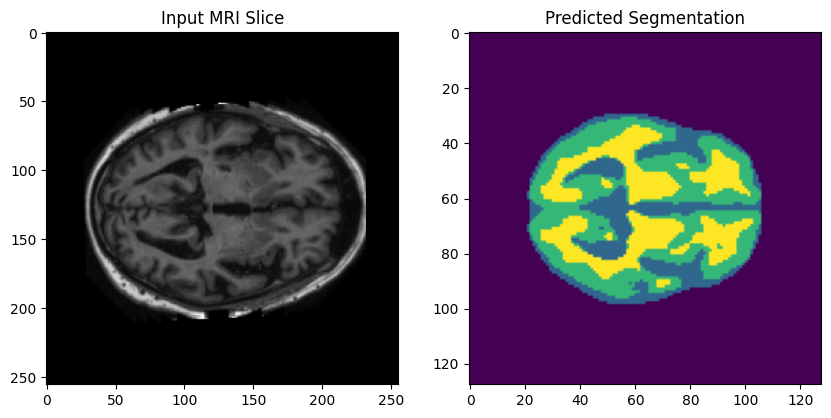

In [21]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ======================
# Config
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 128

# ----------------------
# Define UNet
# ----------------------
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, features=[32, 64, 128]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Down path
        for feature in features:
            self.downs.append(nn.Sequential(
                nn.Conv2d(in_channels, feature, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature, feature, 3, padding=1),
                nn.ReLU(inplace=True)
            ))
            in_channels = feature

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1]*2, features[-1]*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Up path
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(feature*2, feature, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature, feature, 3, padding=1),
                nn.ReLU(inplace=True)
            ))

        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

# ======================
# Load model checkpoint
# ======================
# adjust out_channels = num_classes (detected in training)
num_classes = 4   # example: background + 3 tissue types
model = UNet(in_channels=1, out_channels=num_classes).to(device)
model.load_state_dict(torch.load("/kaggle/input/unet_1/tensorflow2/default/1/unet_best_1.pth", map_location=device))
model.eval()

# ======================
# Preprocess new image
# ======================
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# pick one image from Kaggle dataset
img_path = "/kaggle/input/mri-dataset/keras_png_slices_data/keras_png_slices_test/case_441_slice_0.nii.png"
image = Image.open(img_path).convert("L")
input_tensor = transform(image).unsqueeze(0).to(device)  # [1,1,H,W]

# ======================
# Run inference
# ======================
with torch.no_grad():
    pred = model(input_tensor)              # [1, num_classes, H, W]
    pred_mask = pred.argmax(1).squeeze().cpu().numpy()  # [H,W]

# ======================
# Visualize result
# ======================
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.title("Input MRI Slice")

plt.subplot(1,2,2)
plt.imshow(pred_mask)
plt.title("Predicted Segmentation")
plt.show()
